In [1]:
import os
import sys

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose

from deep4cast.forecasters import Forecaster
from deep4cast.models import WaveNet
from deep4cast.utils import TimeSeriesDataset, RemoveLast, Tensorize, Target
import deep4cast.custom_metrics as metrics

# Make RNG predictable
np.random.seed(0)
torch.manual_seed(0)

%matplotlib inline

# Tutorial: Forecasting Github Daily Active Users

In this notebook, we show how to use Deep4Cast to forecast a single time series of Github daily active users. The data can be gathered from [Github Archive](https://www.gharchive.org/) and is entirely public. The idea here is to show how to handle a short timeseries with many characteristics, e.g., positive values, trending, multiple seasonalities, etc.

# Forecasting parameters

We first need to specify some forecasting parameters.

In [2]:
# (days) of forecasting horizon
horizon = 90
# (days) the lookback window used to chunk up the long time series into smaller windowed training examples
lookback = 256
# which device to run the training on (cpu or gpu)
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Data preparation

The data set consists of only one time series, Github daily active users, that we want to model. In addition, we build a few dummy variables for holidays and such.

In [3]:
# Load the dataset
if not os.path.isfile('../examples/data/processed/github_dau_2011-2018.pkl'):
    # if the data doesn't exist then run the processing script
    %run data/process_github.py --data_path data/raw/github_dau_2011-2018.csv --output_path data/processed/github_dau_2011-2018.pkl
data = pd.read_pickle("../examples/data/processed/github_dau_2011-2018.pkl")
    
# Recalculate training & testing boundary
test_ind = data.index.where(data['date'] == dt.datetime(2017,6,4)).dropna().astype('int').values[0]
data = data.set_index('date')
data_arr = data.values
data_arr = np.expand_dims(data_arr.T, 0) # Get array into right shape for chunking

# Sequentialize the training and testing dataset
data_train, data_test = [], []
for time_series in data_arr:
    data_train.append(time_series[:, :test_ind],)
    data_test.append(time_series[:, test_ind-lookback:])
data_train = np.array(data_train)
data_test = np.array(data_test)

# Bring into Pytorch Dataset framework
transform = Compose(
    [Tensorize(), 
     RemoveLast(targets=[0]), 
     Target(targets=[0])]
)
data_train = TimeSeriesDataset(
    data_train, 
    lookback, 
    horizon, 
    transform=transform
)
data_test = TimeSeriesDataset(
    data_test, 
    lookback, 
    horizon, 
    step=horizon, 
    transform=transform
)

# Create mini-batch data loader
dataloader_train = DataLoader(
    data_train, 
    batch_size=32, 
    shuffle=True, 
    pin_memory=True,
    num_workers=1
)
dataloader_test = DataLoader(
    data_test, 
    batch_size=3, 
    shuffle=False
)

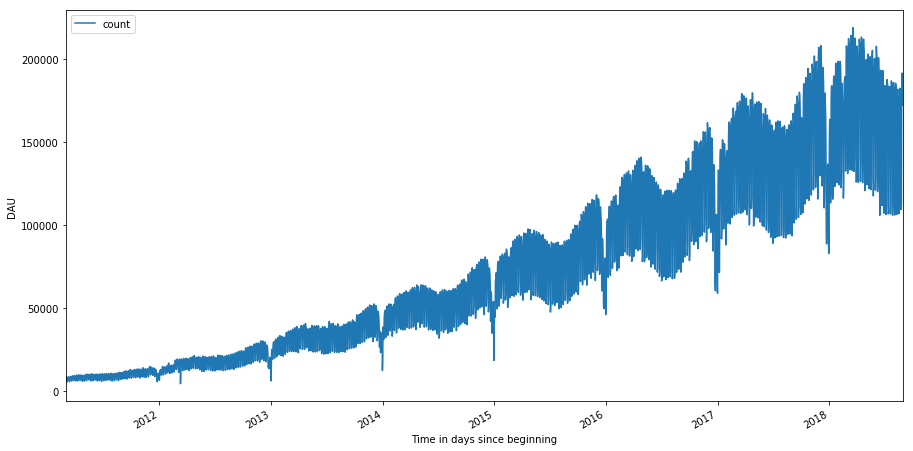

In [4]:
# Let plot the data to help our imagination
data[['count']].apply(np.expm1).plot(subplots=True, figsize=(15, 8))
plt.xlabel('Time in days since beginning')
plt.ylabel('DAU')
plt.show()

# Modeling
The network architecture that we we are using in this example is based on ideas related to WaveNet by DeepMind (see references). We employ the same architecture with a few modifications (e.g., a fully connected output layer for vectorial forecasts). It turns out that we do not need many layers in this example to achieve state-of-the-art results, most likely because of the simple autoregressive nature of the data.

### WaveNet

![architecture](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif)

In many ways, a temporal convoluational architecture is among the simplest possible architecures that we could employ using neural networks. In our approach, every layer has the same number of convoluational filters and used residual connections.

In [5]:
# Define the model architecture
n_layers = 6
model = WaveNet(input_channels=21,
                output_channels=1,
                horizon=horizon, 
                n_layers=n_layers)

# .. and the optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

# .. and the loss
loss = torch.distributions.Normal

# Count the model parameters
print('Number of model parameters: {}.'.format(model.n_parameters))

# Calculate receptive field sizs
print('Receptive field size: {}.'.format(model.receptive_field_size))

Number of model parameters: 116734.
Receptive field size: 64.


In [6]:
# Fit the forecaster
forecaster = Forecaster(model, loss, optim, n_epochs=10, device=device)
forecaster.fit(dataloader_train, eval_model=True)

Number of model parameters being fitted: 116734.
Epoch 1/10 [1940/1940 (98%)]	Loss: 0.043966	Elapsed/Remaining: 0m5s/0m43s   
Training error: 7.59e+00.
Epoch 2/10 [1940/1940 (98%)]	Loss: -0.156904	Elapsed/Remaining: 0m10s/0m42s   
Training error: -2.01e+01.
Epoch 3/10 [1940/1940 (98%)]	Loss: -0.342942	Elapsed/Remaining: 0m17s/0m39s   
Training error: -3.69e+01.
Epoch 4/10 [1940/1940 (98%)]	Loss: -0.732276	Elapsed/Remaining: 0m23s/0m34s   
Training error: -4.65e+01.
Epoch 5/10 [1940/1940 (98%)]	Loss: -0.603687	Elapsed/Remaining: 0m29s/0m29s   
Training error: -4.93e+01.
Epoch 6/10 [1940/1940 (98%)]	Loss: -0.764116	Elapsed/Remaining: 0m34s/0m23s   
Training error: -5.75e+01.
Epoch 7/10 [1940/1940 (98%)]	Loss: -0.557223	Elapsed/Remaining: 0m40s/0m17s   
Training error: -6.23e+01.
Epoch 8/10 [1940/1940 (98%)]	Loss: -0.755617	Elapsed/Remaining: 0m46s/0m11s   
Training error: -6.72e+01.
Epoch 9/10 [1940/1940 (98%)]	Loss: -0.857866	Elapsed/Remaining: 0m51s/0m6s   
Training error: -7.12e+01.
E

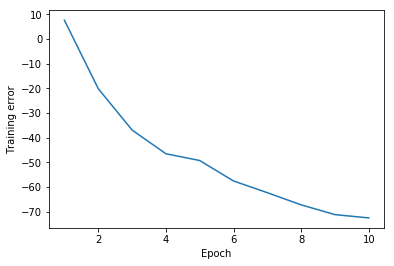

In [7]:
# Let's plot the training error
plt.plot(range(1, forecaster.n_epochs+1), forecaster.history['training'])
plt.xlabel('Epoch')
plt.ylabel('Training error')
plt.show()

# Evaluation

Before any evaluation score can be calculated, we need to transform the output forecasts.

In [8]:
# Get time series of actuals for the testing period
y_test_actual_raw, y_test_actual_offset = [], []
for sample in dataloader_test:
    y_test_actual_raw.append(sample['y'].cpu().numpy())
    y_test_actual_offset.append(sample['RemoveLast_offset'].cpu().numpy())
y_test_actual_raw = np.concatenate(y_test_actual_raw, axis=0)
y_test_actual_offset = np.concatenate(y_test_actual_offset, axis=0)
y_test_actual = y_test_actual_raw + y_test_actual_offset[:, :, None]

y_test_actual = np.reshape(y_test_actual, y_test_actual.shape[0]*y_test_actual.shape[2])
y_test_actual = np.expm1(y_test_actual)

# Get corresponding predictions
# The samples are of the shape (n_samples, n_series, n_covariates, n_timesteps), whereas the actuals are of the shape
# (n_series, n_covariates, n_timesteps)
raw_samples = forecaster.predict(dataloader_test, n_samples=100)
y_test_samples = []
for i in range(raw_samples.shape[1]):
    y_test_samples.append(raw_samples[:,i,:] + y_test_actual_offset[i])
        
y_test_samples = np.concatenate(y_test_samples, axis=-1)
y_test_samples = np.expm1(y_test_samples)

y_test_mean = np.mean(y_test_samples, axis=0)
y_test_lq = np.percentile(y_test_samples, q=5, axis=0)
y_test_uq = np.percentile(y_test_samples, q=95, axis=0)

We calculate the symmetric MAPE and pinball loss, as well as the empirical coverage for the test set data.

SMAPE: 6.716%
Coverage: 


Text(0, 0.5, 'model percentile')

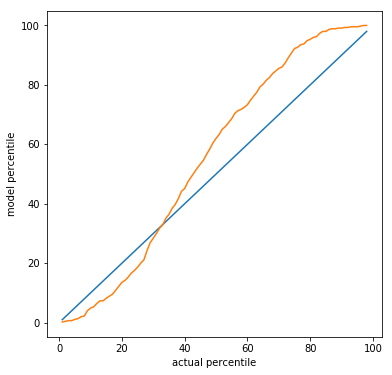

In [9]:
# Evaluate forecasts
test_smape = metrics.smape(y_test_samples, y_test_actual)
test_perc = np.arange(1, 99)
test_cov = metrics.coverage(y_test_samples, y_test_actual, percentiles=test_perc)

print('SMAPE: {}%'.format(test_smape))
print('Coverage: ')

plt.figure(figsize=(6, 6))
plt.plot(test_perc, test_perc)
plt.plot(test_perc, test_cov)
plt.xlabel('actual percentile')
plt.ylabel('model percentile')
plt.xlabel('actual percentile')
plt.ylabel('model percentile')

Let's have a closer look at what a forecast looks like. We can use the model output to graph the mean, upper and lower confidence intervals, and some samples.

Text(0, 0.5, 'DAU')

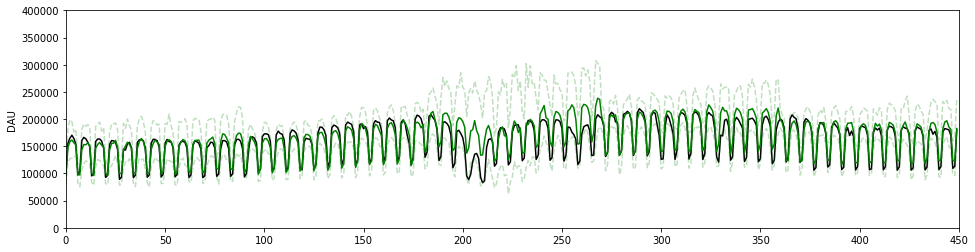

In [10]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(16, 4))

plt.plot(y_test_actual, 'k-')
plt.plot(y_test_mean.T, 'g-')
plt.plot(y_test_uq.T, 'g--', alpha=0.25)
plt.plot(y_test_lq.T, 'g--', alpha=0.25)

plt.ylim([0, 0.4e6])
plt.xlim([0, y_test_actual.shape[-1]])

plt.ylabel('DAU')

# References
[WaveNet Paper](https://arxiv.org/abs/1609.03499)

[Comparison of CNNs to RNNs for sequence modeling](https://arxiv.org/abs/1803.01271)

[Conditional time series forecasting with CNNs](https://arxiv.org/abs/1703.04691)